# N1

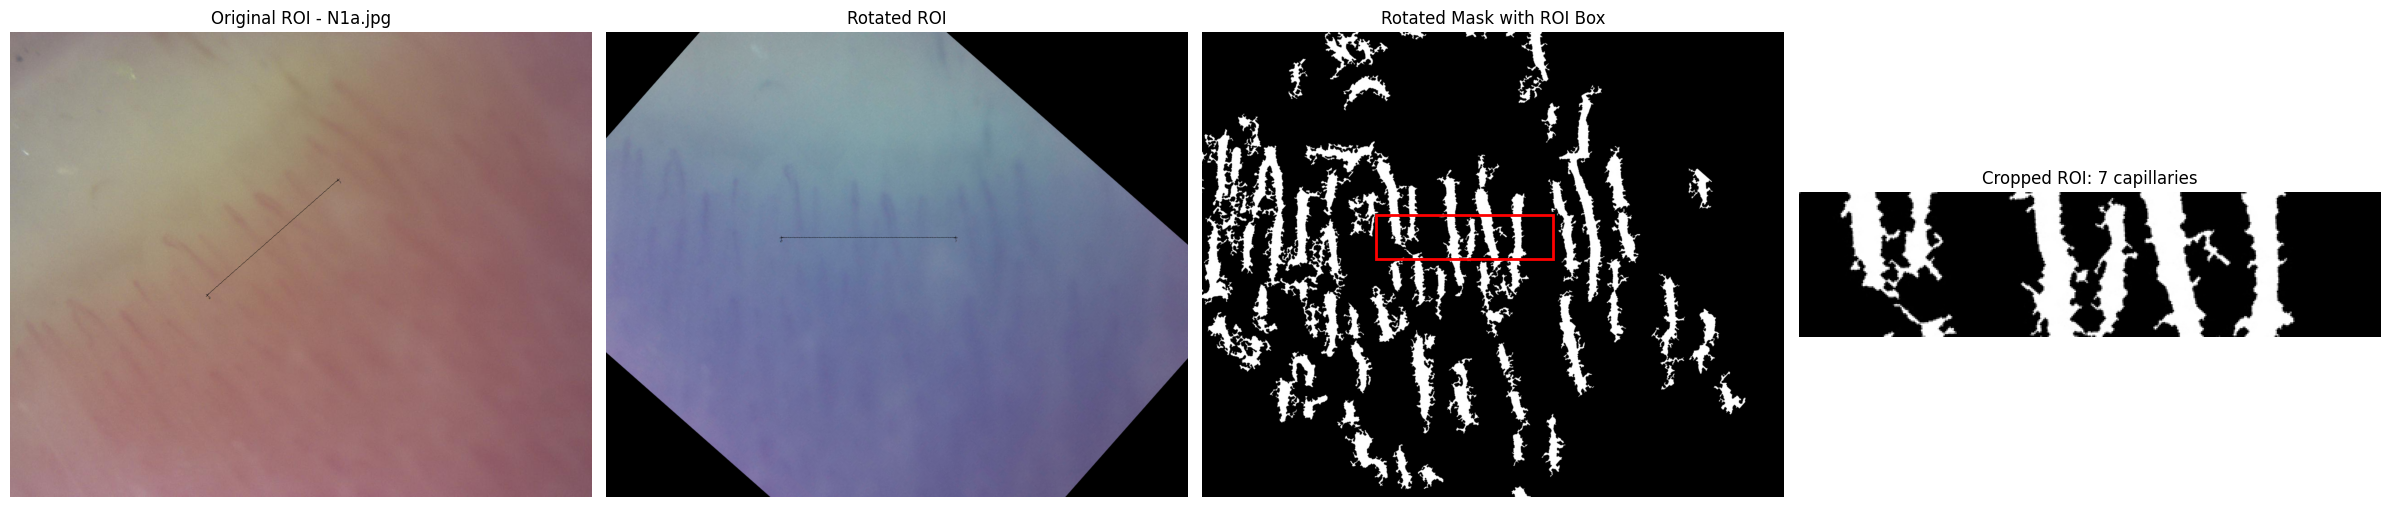

✅ N1a.jpg: 7 capillaries detected


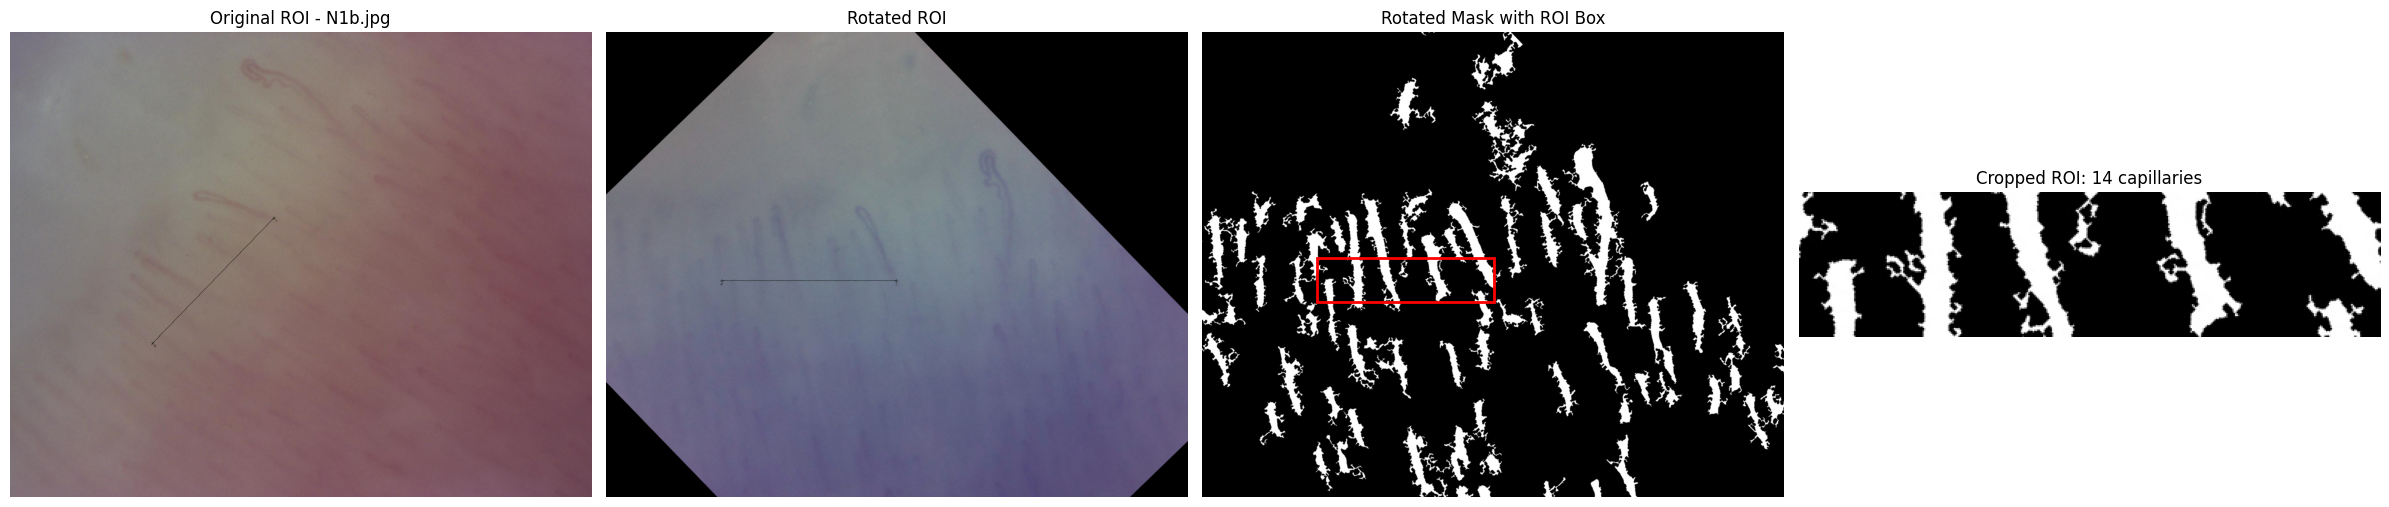

✅ N1b.jpg: 14 capillaries detected


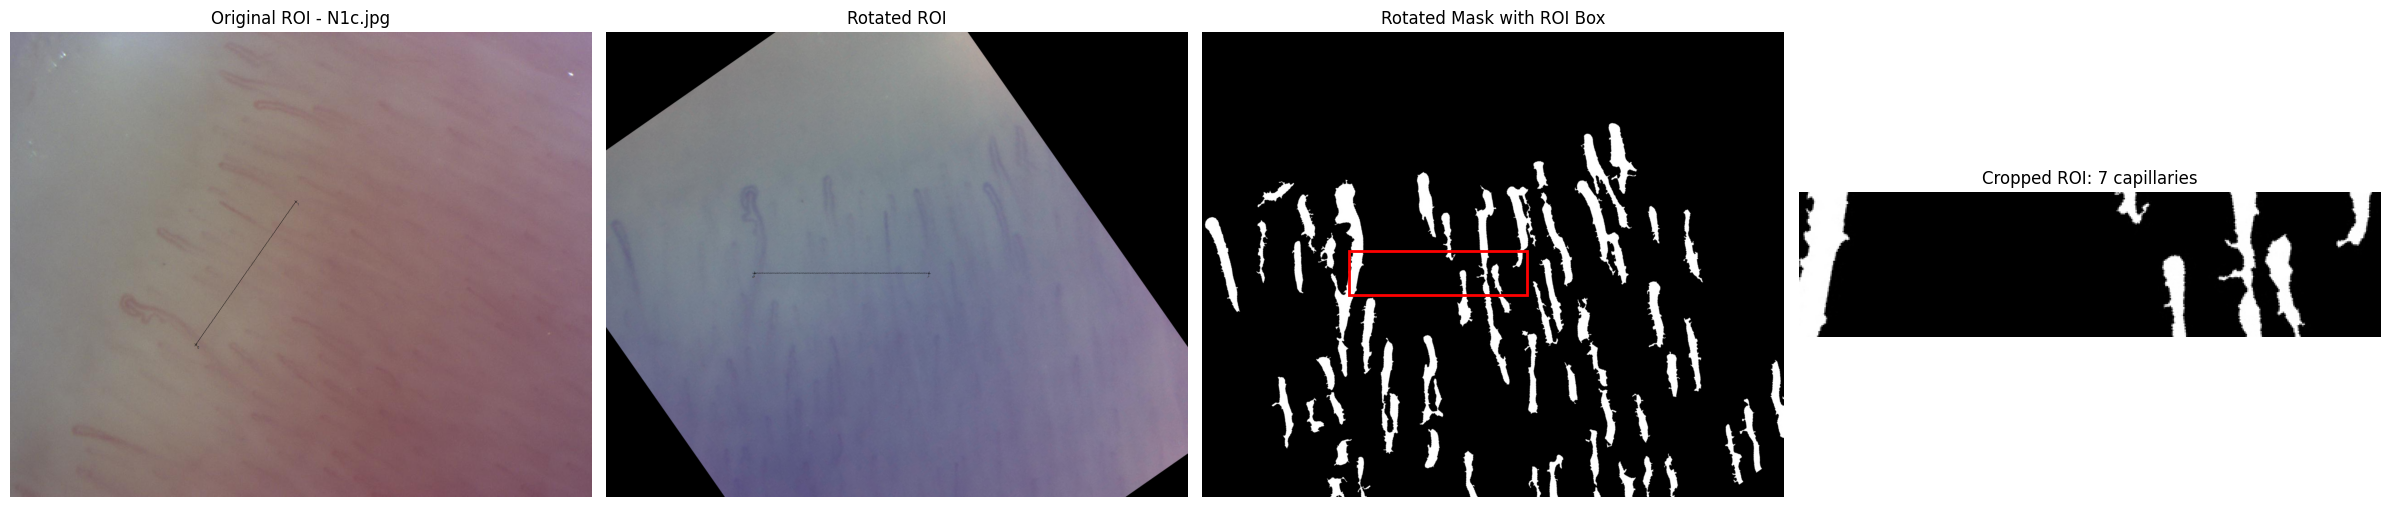

✅ N1c.jpg: 7 capillaries detected


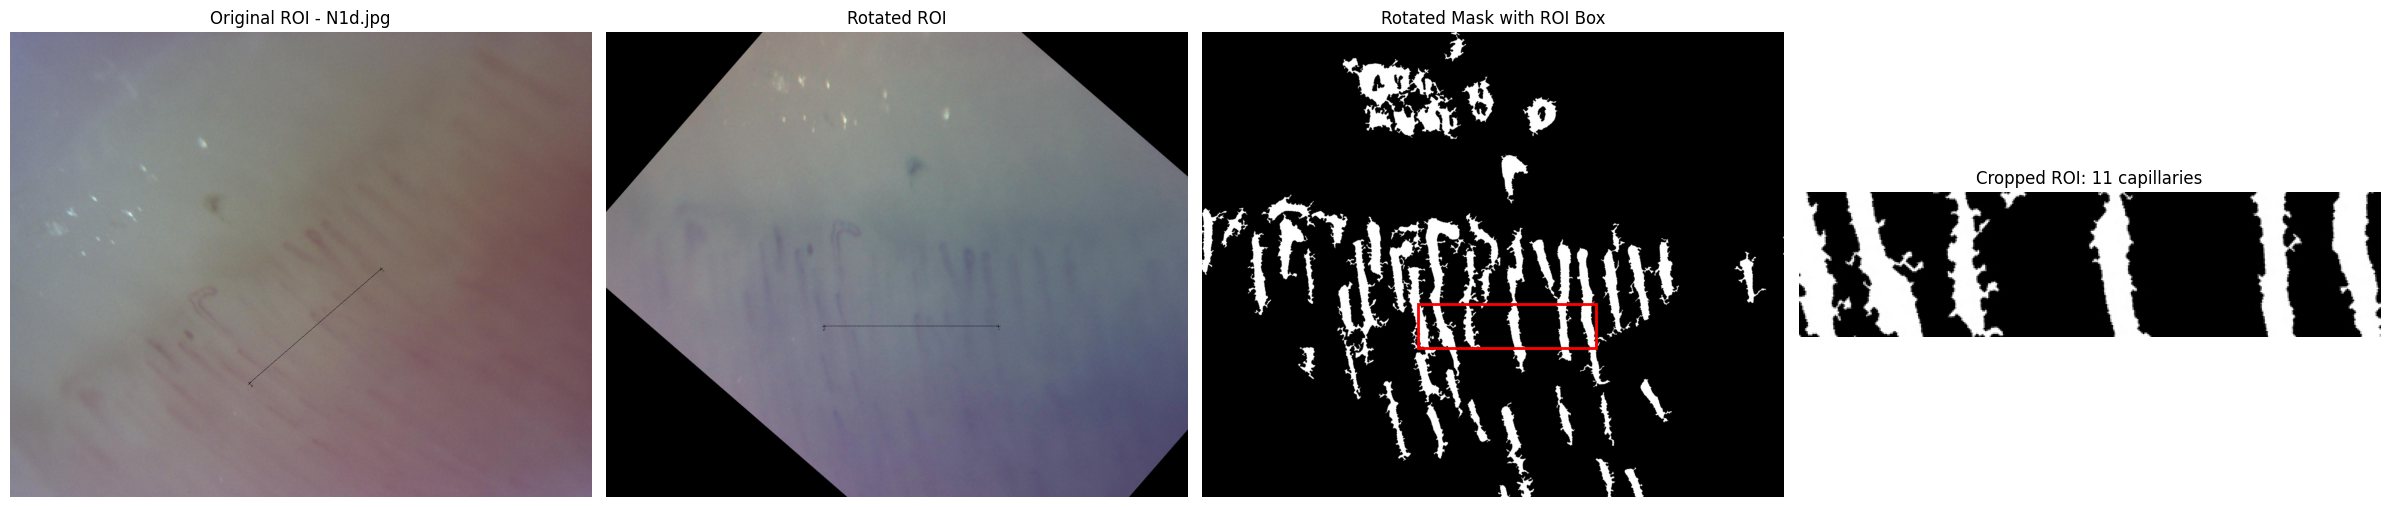

✅ N1d.jpg: 11 capillaries detected


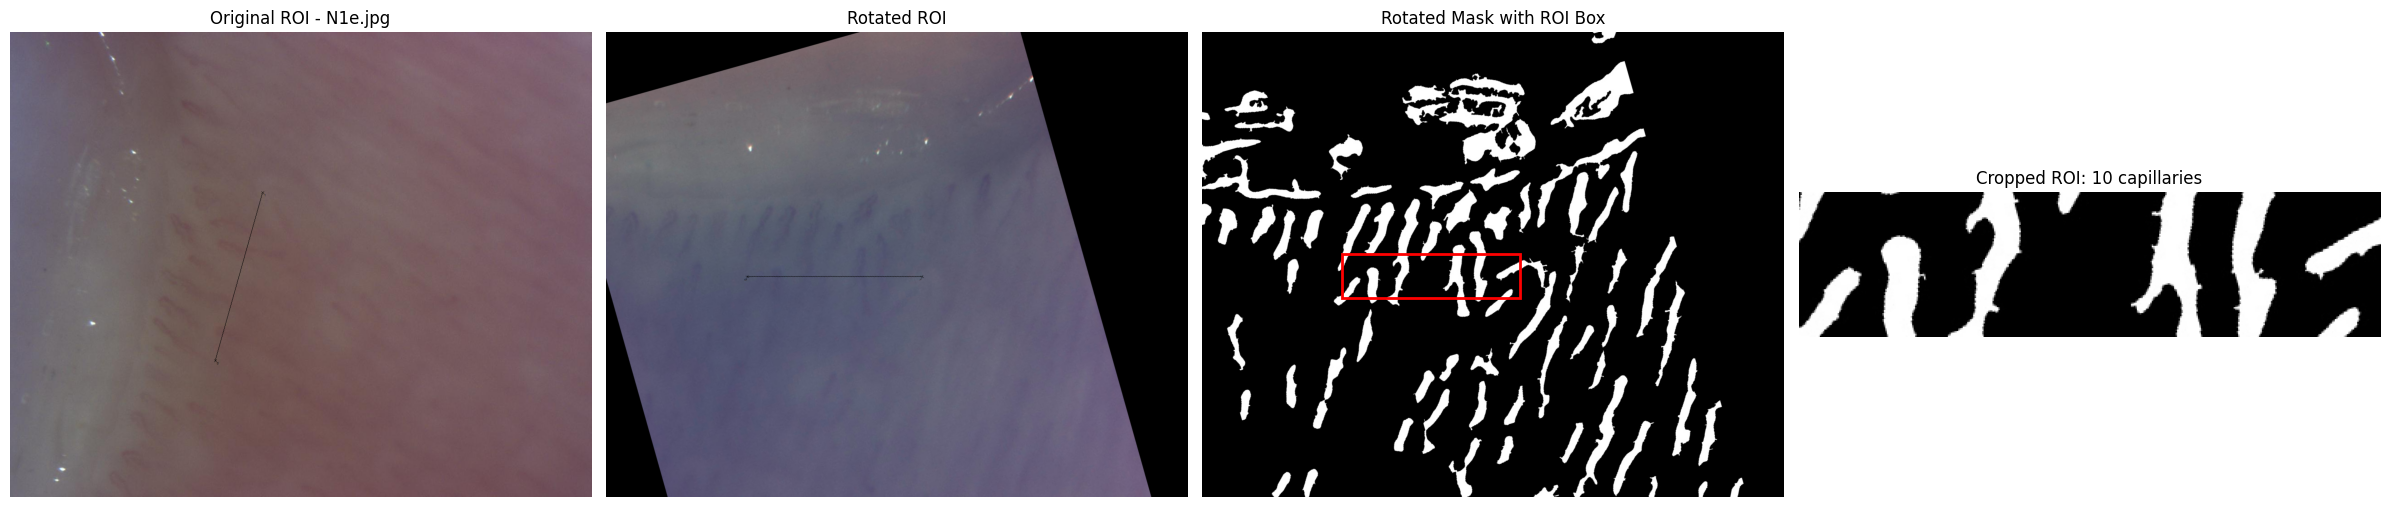

✅ N1e.jpg: 10 capillaries detected


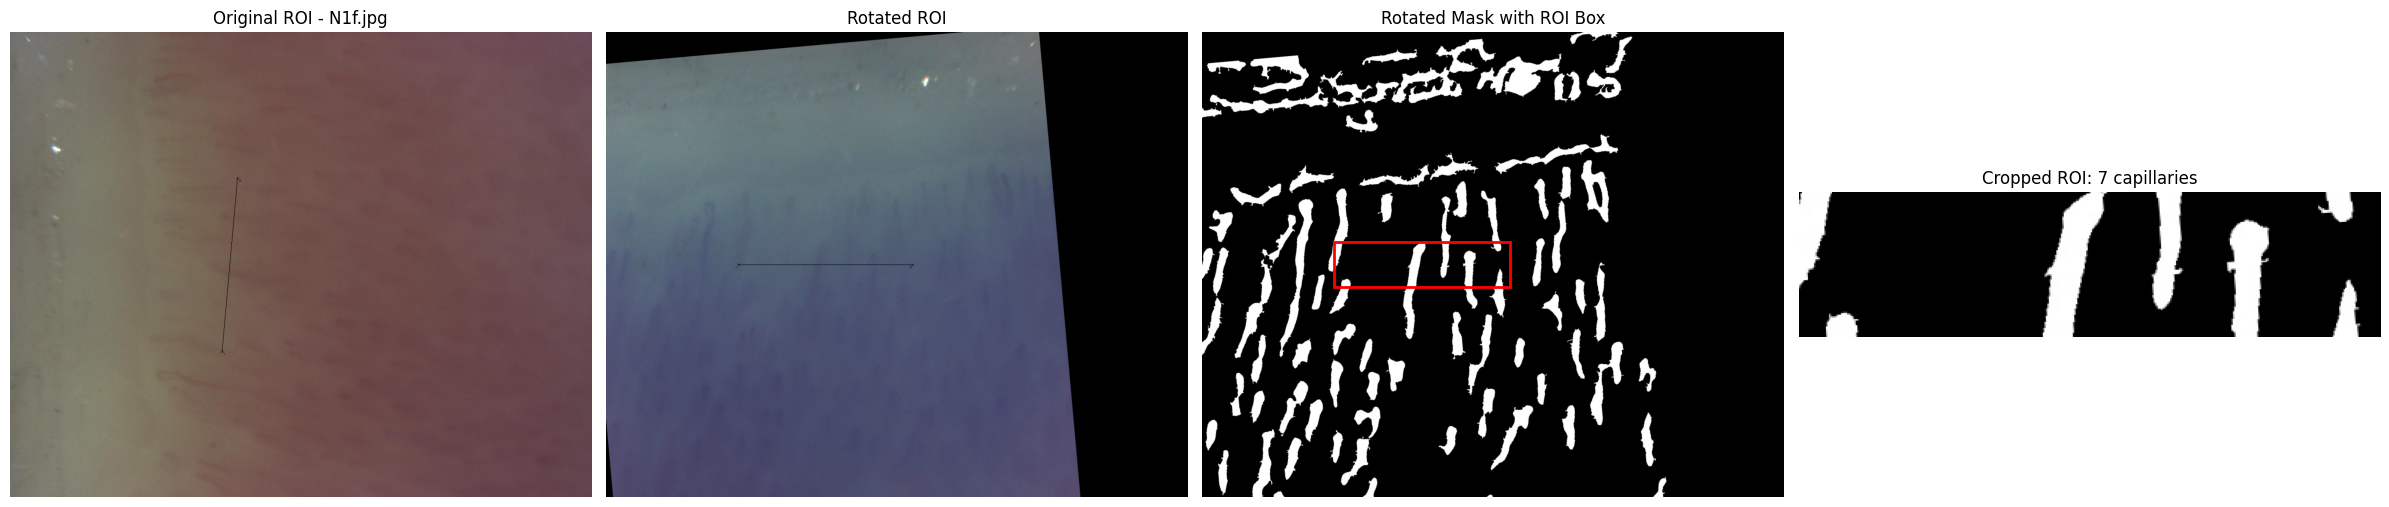

✅ N1f.jpg: 7 capillaries detected


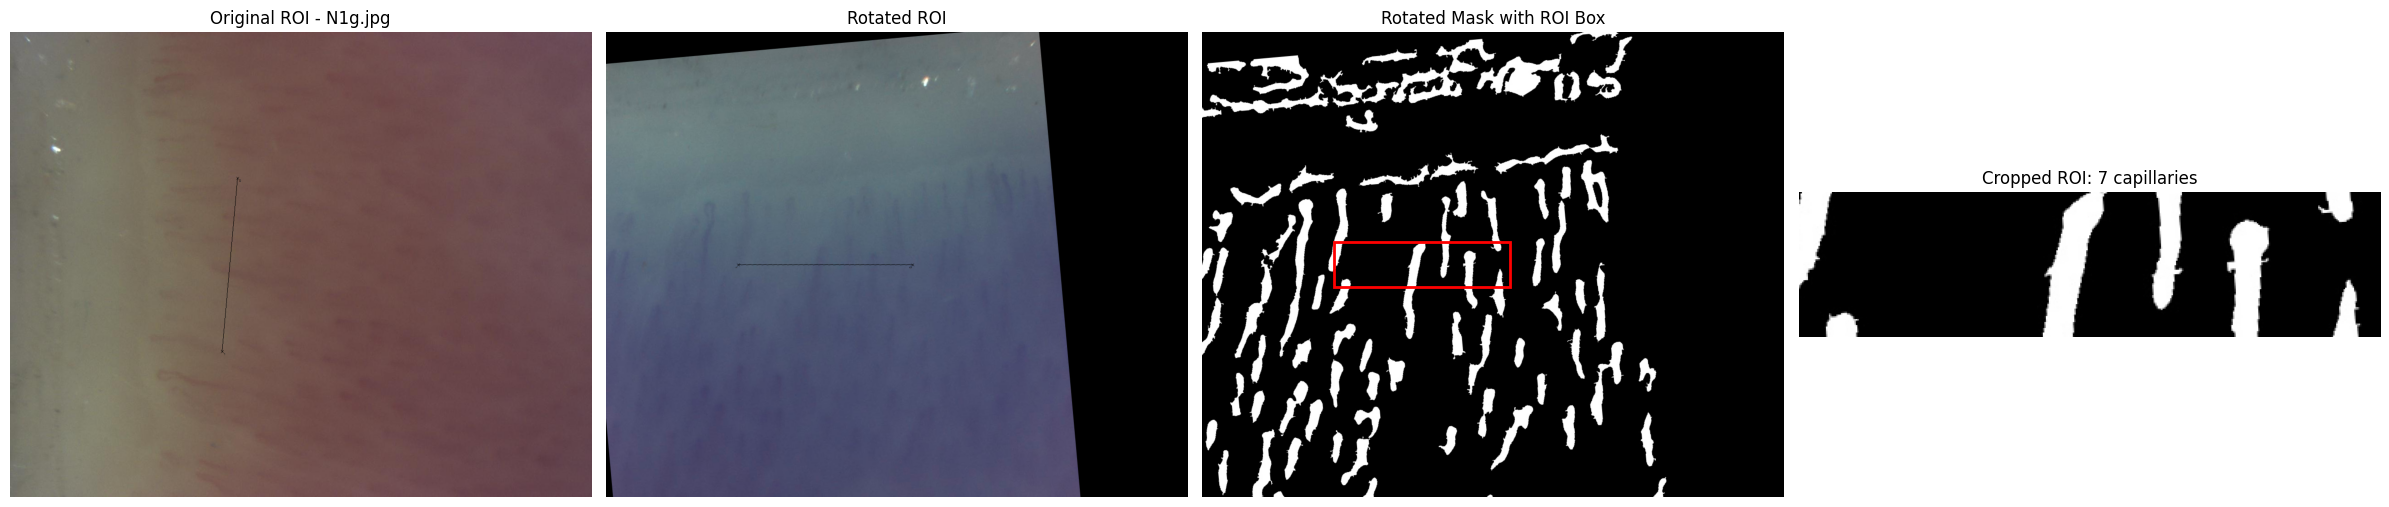

✅ N1g.jpg: 7 capillaries detected


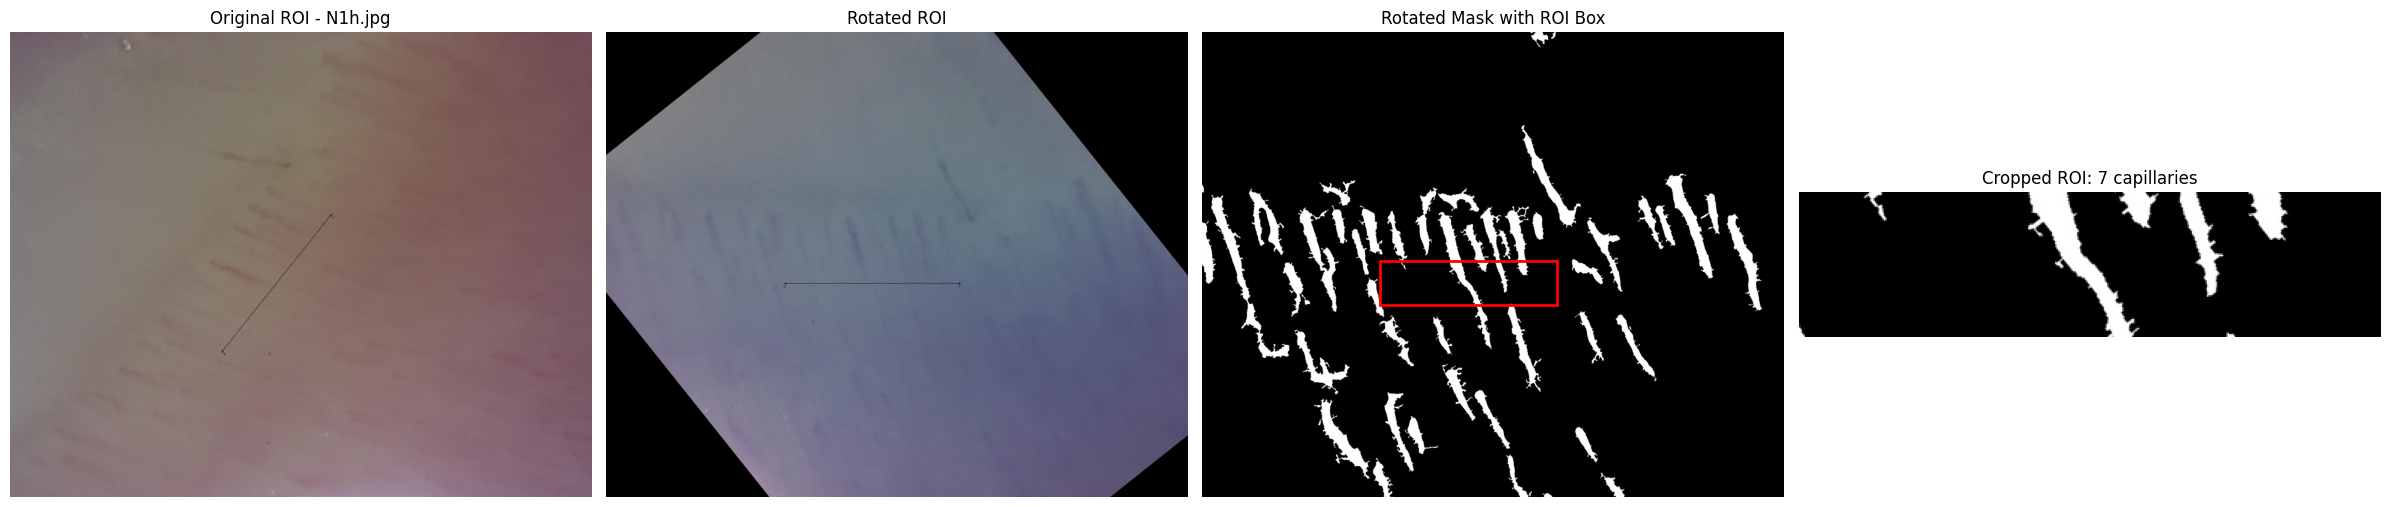

✅ N1h.jpg: 7 capillaries detected


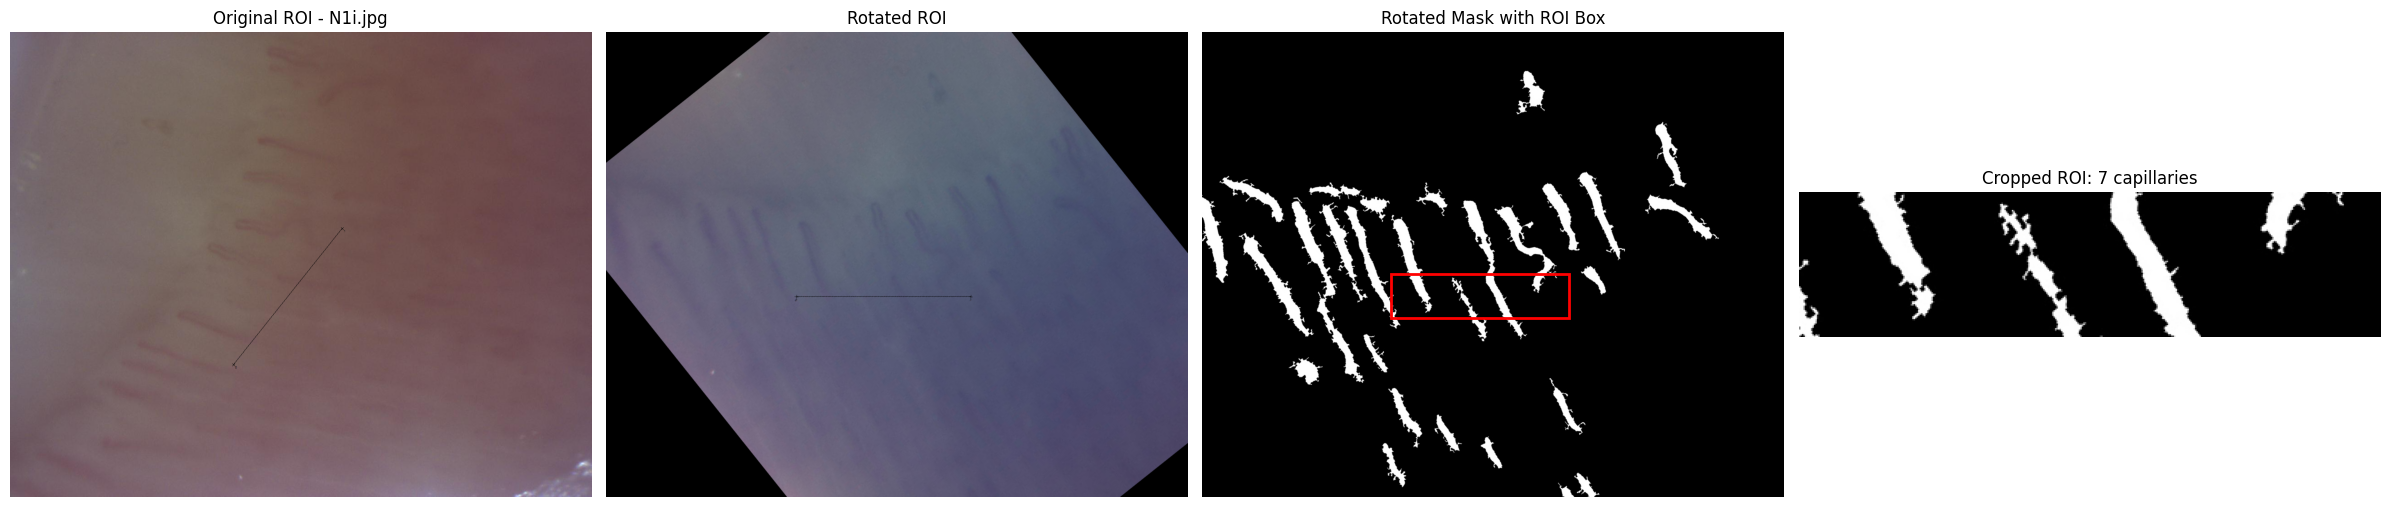

✅ N1i.jpg: 7 capillaries detected


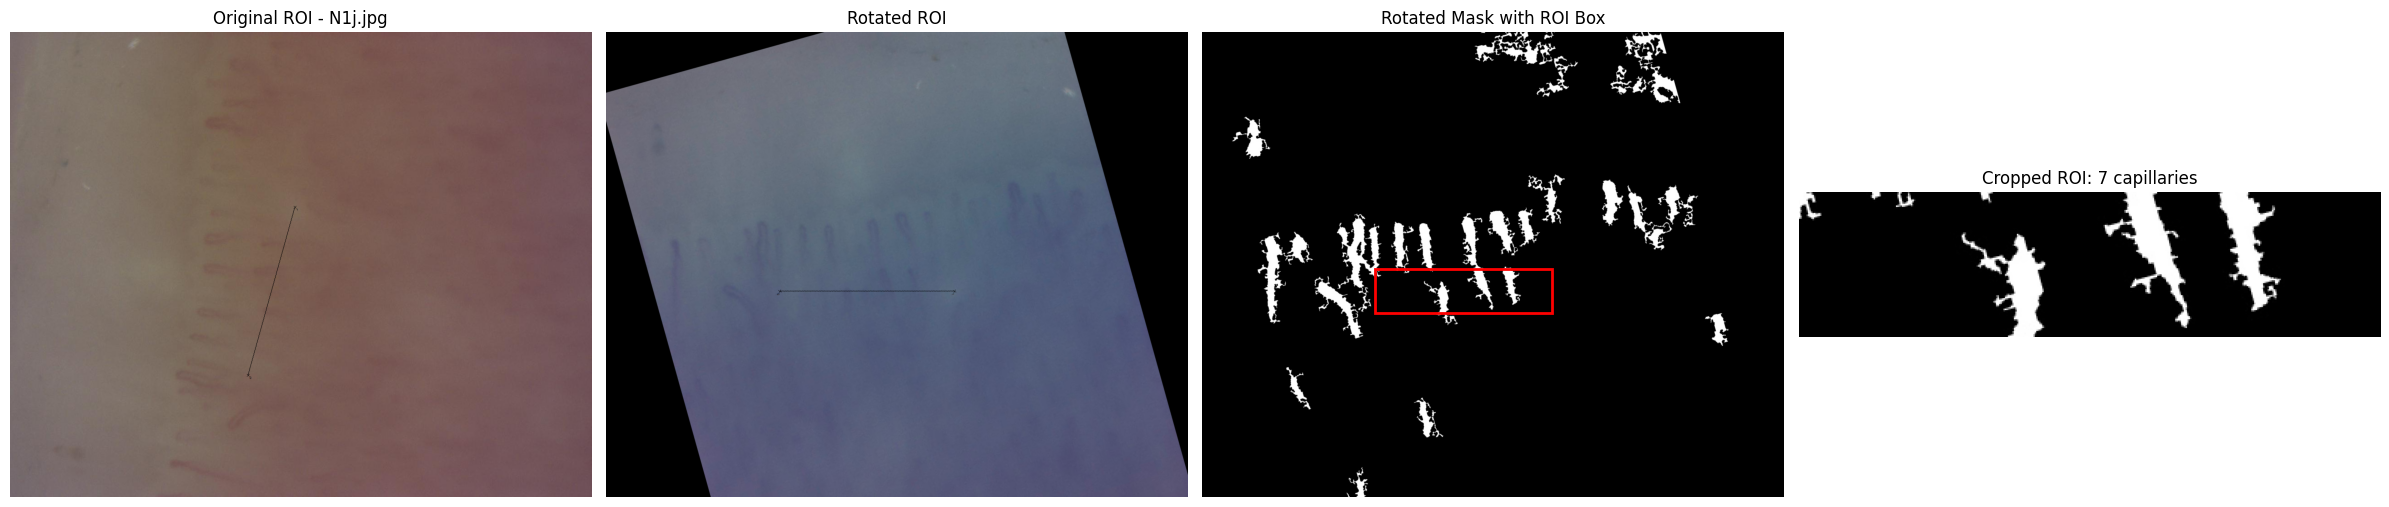

✅ N1j.jpg: 7 capillaries detected
📁 Results saved to: Count Capillaries\CSV\capillary_counts_N1.csv


In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle

# Define folders
roi_folder = 'Dataset/Region of Interest/N1_ROI'
mask_folder = 'Segmented/N1_Native_Segmentation/Masks'

# Create output directories
output_dir = 'Count Capillaries'
csv_dir = os.path.join(output_dir, 'CSV')
visuals_dir = os.path.join(output_dir, 'Visuals')
n1_visuals_dir = os.path.join(visuals_dir, 'N1')
os.makedirs(n1_visuals_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)
os.makedirs(visuals_dir, exist_ok=True)

results = []

def rotate_image(image, angle, center):
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, (image.shape[1], image.shape[0]))
    return result, rot_mat

def apply_rotation_to_points(points, rot_mat):
    ones = np.ones(shape=(len(points), 1))
    points_ones = np.hstack([points, ones])
    rotated_points = rot_mat.dot(points_ones.T).T
    return rotated_points

def process_image(roi_path, mask_path, filename):
    roi_img = cv2.imread(roi_path)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if roi_img is None or mask_img is None:
        print(f"❌ Error loading image: {filename}")
        return

    # Step 1: Detect black line in ROI
    gray = cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)
    blur = cv2.GaussianBlur(gray, (5, 5), 3)
    ret3, th3 = cv2.threshold(gray, 125, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"⚠️ No black line found in {filename}")
        return

    black_line = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(black_line)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    center = tuple(np.mean(box, axis=0))
    angle = rect[2]
    if rect[1][0] < rect[1][1]:
        angle = angle - 90

    # Rotate both images
    rotated_roi, rot_mat = rotate_image(roi_img, angle, center)
    rotated_mask, _ = rotate_image(mask_img, angle, center)

    # Step 2: Calculate bounding box dimensions
    box_rotated = apply_rotation_to_points(box, rot_mat).astype(int)
    x_min, y_min = np.min(box_rotated, axis=0)
    x_max, y_max = np.max(box_rotated, axis=0)

    length = int(np.linalg.norm(box_rotated[0] - box_rotated[1]))
    width = int(length / 4)

    # Step 3: Define final bounding box
    mid_y = int((y_min + y_max) / 2)
    mid_x = int((x_min + x_max) / 2)
    top_left_x = mid_x - length // 2
    top_left_y = mid_y - width // 2

    roi_crop = rotated_mask[top_left_y:top_left_y + width, top_left_x:top_left_x + length]

    # Count connected components inside cropped mask
    _, binary = cv2.threshold(roi_crop, 127, 255, cv2.THRESH_BINARY)
    num_labels, labels = cv2.connectedComponents(binary)

    # Save results
    results.append({'filename': filename, 'capillary_count': num_labels - 1})

    # Visualization (4 subplots)
    fig, ax = plt.subplots(1, 4, figsize=(24, 5))
    ax[0].imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"Original ROI - {filename}")
    ax[0].axis('off')

    ax[1].imshow(rotated_roi, cmap='gray')
    ax[1].set_title("Rotated ROI")
    ax[1].axis('off')

    ax[2].imshow(rotated_mask, cmap='gray')
    ax[2].add_patch(Rectangle((top_left_x, top_left_y), length, width, linewidth=2, edgecolor='r', facecolor='none'))
    ax[2].set_title("Rotated Mask with ROI Box")
    ax[2].axis('off')

    ax[3].imshow(roi_crop, cmap='gray')
    ax[3].set_title(f"Cropped ROI: {num_labels - 1} capillaries")
    ax[3].axis('off')

    plt.tight_layout()
    # Save figure to 'Visuals' folder
    fig_filename = os.path.join(n1_visuals_dir, filename.replace('.jpg', '_visual.png'))
    plt.savefig(fig_filename)
    plt.show()
    plt.close()

    print(f"✅ {filename}: {num_labels - 1} capillaries detected")

# Main loop
for filename in sorted(os.listdir(roi_folder)):
    if filename.endswith('.jpg'):
        roi_path = os.path.join(roi_folder, filename)
        mask_name = filename.replace('.jpg', '_Natif.jpg')
        mask_path = os.path.join(mask_folder, mask_name)
        process_image(roi_path, mask_path, filename)

# Export to CSV
df = pd.DataFrame(results)
csv_output_path = os.path.join(csv_dir, 'capillary_counts_N1.csv')
df.to_csv(csv_output_path, index=False)
print(f"📁 Results saved to: {csv_output_path}")
